In [2]:
import torch
import torch.nn as nn
from torch.distributions import Normal
import pandas as pd
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

In [27]:

class LDMprobit(torch.nn.Module):
    def __init__(self, Aij, thresholds, embedding_dim, device, n_epochs, lr, seed=0):
        super(LDMprobit, self).__init__()
        self.Aij = Aij.to(device)
        self.thresholds = thresholds.to(device)
        self.device = device
        self.n_drugs, self.n_effects = Aij.shape
        self.n_ordinal_classes = (len(thresholds) - 1)

        #set seed
        self.seed = seed
        self.__set_seed(seed)

        #Variables for the learning process
        self.n_epochs = n_epochs
        self.lr = lr

        #parameters to be learned
        self.beta = nn.Parameter(torch.randn(self.n_effects, device=device))
        self.w = torch.nn.Parameter(torch.randn(self.n_drugs, embedding_dim, device=device))  # Latent embeddings for drugs
        self.v = torch.nn.Parameter(torch.randn(self.n_effects, embedding_dim, device=device))  # Latent embeddings for side effects
        self.beta_thilde = nn.Parameter(torch.randn(self.n_ordinal_classes, device=device))
    
    def __set_seed(self, seed):
        if seed is not None:
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

    def get_embeddings(self):
        return self.w, self.v
    
    def get_thresholds(self):
        softmax_beta = torch.softmax(self.beta_thilde, dim=0)

    def probit(self):
        #n_ordinal_classes = len(self.thresholds) - 1
        #n_drugs, n_effects = self.Aij.shape
        normal_dist = Normal(0, 1) # Noise contaminated by normal distribution
        probit_matrix = torch.zeros((self.n_drugs, self.n_effects, self.n_ordinal_classes), device=self.device)

    
        #Linear term (\beta^T x_{i,j})
        linear_term = torch.matmul(self.Aij, self.beta.unsqueeze(1))

        # Distance term -|w_i - v_j|
        dist = -torch.norm(self.w.unsqueeze(1) - self.v.unsqueeze(0), dim=2)

        # Latent variable \beta^T x_{i,j} + \alpha(u_i - u_j)
        latent_var = linear_term + dist
        
        for y in range(self.n_ordinal_classes):
            z1 = latent_var - self.thresholds[y]
            z2 = latent_var - self.thresholds[y+1]
            probit_matrix[:, :, y] = normal_dist.cdf(z1) - normal_dist.cdf(z2)
        return probit_matrix

    def ordinal_cross_entropy_loss(self):
    # Compute the predicted probabilities using the probit function
        probit_matrix = self.probit() 

        # Initialize loss variable
        loss = 0.0

        # Iterate over all drugs and side effects
        for i in range(self.n_drugs):  # For each drug
            for j in range(self.n_effects):  # For each side effect
                if self.Aij[i, j] != 0:  # Only compute loss for nonzero entries
                    target_class = int(self.Aij[i, j]) - 1  # Convert severity to class (0-based)
                    
                    #One-hot encode target 
                    one_hot_target = torch.zeros(self.n_ordinal_classes, device=self.device)
                    one_hot_target[target_class] = 1  # Set the correct class to 1

                    # Compute the log-likelihood 
                    prob = probit_matrix[i, j]
                    loss -= torch.log(torch.sum(prob * one_hot_target) + 1e-8)  # Negative log-likelihood, addition of small number to avoid log(0)

        return loss
    
    def forward(self):
        return self.probit()
        
    def learn(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

        for epoch in range(self.n_epochs):
            avg_loss = self.train_one_epoch(optimizer)
            print(f"Epoch {epoch+1}/{self.n_epochs}, Loss: {avg_loss:.4f}")
        return self.ordinal_cross_entropy_loss()

    
    def train_one_epoch(self, optimizer, batch_size=32):
        total_loss = 0
        n_batches = (self.n_drugs + batch_size - 1) // batch_size
        for _ in range(n_batches):
            batch_loss = self.train_one_batch(optimizer)
            total_loss += batch_loss
        return total_loss / n_batches
    

    def train_one_batch(self, optimizer):
        optimizer.zero_grad()
        loss = self.ordinal_cross_entropy_loss()
        loss.backward()
        optimizer.step()
        return loss.item()

    def get_params(self):
        return self.beta, self.w.detach().cpu(), self.v.detach().cpu()

    def save_embeddings():
        raise NotImplementedError

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 4
Aij = torch.tensor([[0, 2, 0, 3, 1, 2], 
                    [0, 0, 0, 0, 1, 2],
                    [0, 0, 2, 0, 1, 2],
                    [3, 3, 0, 0, 0, 1],
                    [3, 3, 0, 0, 0, 1],
                    [0, 0, 2, 0, 0, 0]],dtype=torch.float32) #column: side effect, row:drug, value: frequency (ordinal)
thresholds = torch.tensor([0, 1, 2,3], dtype=torch.float32, device=device) 
n_epochs = 100
lr = 0.01
seed = 42
model = LDMprobit(Aij, thresholds, embedding_dim, device, n_epochs, lr, seed)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.ordinal_cross_entropy_loss()  # Compute the ordinal cross-entropy loss
print(loss_out)

tensor(140.2836, grad_fn=<SubBackward0>)


In [4]:
model = LDMprobit(Aij, thresholds, embedding_dim, device, n_epochs, lr, seed).to(device)

# Run a forward pass
probit_output = model.forward()  # Should return a probability matrix
print("\nProbit Output Shape:", probit_output.shape)  # Expect (n_drugs, n_effects, n_ordinal_classes)
print(probit_output)


Probit Output Shape: torch.Size([6, 6, 3])
tensor([[[4.9788e-04, 9.0003e-06, 5.9605e-08],
         [1.5269e-03, 3.7998e-05, 3.5763e-07],
         [1.9052e-02, 1.1198e-03, 2.5451e-05],
         [1.2656e-02, 6.3485e-04, 1.2279e-05],
         [6.7136e-04, 1.3202e-05, 8.9407e-08],
         [2.6510e-02, 1.7850e-03, 4.6521e-05]],

        [[8.6129e-06, 5.9605e-08, 0.0000e+00],
         [3.2783e-07, 0.0000e+00, 0.0000e+00],
         [6.9588e-05, 7.7486e-07, 0.0000e+00],
         [1.5327e-04, 2.0564e-06, 0.0000e+00],
         [6.1095e-06, 2.9802e-08, 0.0000e+00],
         [4.3716e-03, 1.5101e-04, 2.0266e-06]],

        [[7.9435e-04, 1.6361e-05, 1.1921e-07],
         [6.7288e-04, 1.3232e-05, 8.9407e-08],
         [1.5348e-04, 2.0564e-06, 0.0000e+00],
         [3.2181e-03, 1.0064e-04, 1.2219e-06],
         [6.9737e-06, 5.9605e-08, 0.0000e+00],
         [1.2899e-03, 3.0547e-05, 2.6822e-07]],

        [[7.4274e-02, 8.1477e-03, 3.4806e-04],
         [2.1345e-01, 4.7558e-02, 4.1633e-03],
         [

In [5]:
loss = model.ordinal_cross_entropy_loss()
print("\nInitial Loss:", loss.item())


Initial Loss: 140.28363037109375


In [6]:
final_loss = model.learn()
print("\nFinal Loss after training:", final_loss.item())

Epoch 1/100, Loss: 140.2836
Epoch 2/100, Loss: 135.2570
Epoch 3/100, Loss: 130.4330
Epoch 4/100, Loss: 125.6264
Epoch 5/100, Loss: 120.9683
Epoch 6/100, Loss: 116.4607
Epoch 7/100, Loss: 112.0867
Epoch 8/100, Loss: 107.8558
Epoch 9/100, Loss: 103.7523
Epoch 10/100, Loss: 99.7886
Epoch 11/100, Loss: 95.9601
Epoch 12/100, Loss: 92.2697
Epoch 13/100, Loss: 88.7115
Epoch 14/100, Loss: 85.2891
Epoch 15/100, Loss: 81.9993
Epoch 16/100, Loss: 78.8410
Epoch 17/100, Loss: 75.8114
Epoch 18/100, Loss: 72.9087
Epoch 19/100, Loss: 70.1308
Epoch 20/100, Loss: 67.4750
Epoch 21/100, Loss: 64.9386
Epoch 22/100, Loss: 62.5187
Epoch 23/100, Loss: 60.2124
Epoch 24/100, Loss: 58.0167
Epoch 25/100, Loss: 55.9284
Epoch 26/100, Loss: 53.9441
Epoch 27/100, Loss: 52.0607
Epoch 28/100, Loss: 50.2746
Epoch 29/100, Loss: 48.5823
Epoch 30/100, Loss: 46.9804
Epoch 31/100, Loss: 45.4653
Epoch 32/100, Loss: 44.0335
Epoch 33/100, Loss: 42.6813
Epoch 34/100, Loss: 41.4052
Epoch 35/100, Loss: 40.2016
Epoch 36/100, Loss: 

In [7]:
embeddings = model.get_embeddings()
print("\nDrug Embeddings Shape:", embeddings)  # Expect (n_drugs, embedding_dim)


Drug Embeddings Shape: (Parameter containing:
tensor([[-1.6160e-01, -8.6177e-01, -6.4739e-02, -6.9357e-02],
        [ 9.7362e-01, -6.4254e-04, -7.6793e-01,  4.6644e-01],
        [ 3.4032e-01, -2.2731e-01, -2.5780e-01, -1.2938e-01],
        [-5.9368e-01,  7.0658e-01,  1.2925e+00, -7.3862e-01],
        [-1.0748e+00,  1.6601e+00, -6.0845e-01, -2.0983e-01],
        [-7.3827e-01,  1.8250e-01, -1.3402e-01,  1.4241e+00]],
       requires_grad=True), Parameter containing:
tensor([[-0.3419,  0.5940, -0.2796, -0.7263],
        [-0.6393, -0.3567,  1.2285, -0.0053],
        [-0.2839, -0.4386, -0.1742,  1.0432],
        [-0.0854, -0.7435, -0.8099, -0.1415],
        [ 0.1478,  0.5450, -0.9764,  0.8719],
        [ 1.0128, -0.0404, -0.7769,  0.4449]], requires_grad=True))


In [8]:
beta, w, v = model.get_params()
print(beta)

Parameter containing:
tensor([ 0.6966,  0.5053,  0.8986,  0.6356, -0.5180,  0.3786],
       requires_grad=True)


## Trying on real data

In [2]:
def load_data(path_to_csv, device):
    df = pd.read_csv(path_to_csv, index_col=0)
    Aij = torch.tensor(df.values, dtype=torch.float32).to(device)
    return Aij

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
csv_path = "/Users/christine/Bachelor/src/data/adj_matrix.csv" 
Aij_real = load_data(csv_path, device)
print(Aij_real.shape)

torch.Size([968, 3964])


In [11]:
# Define thresholds for ordinal categories
thresholds = torch.tensor([0, 1, 2, 3], dtype=torch.float).to(device)  # Adjust as needed

# Define model hyperparameters
embedding_dim = 5  # Number of dimensions in latent space
n_epochs = 50
lr = 0.01
seed = 42

# Initialize the model
model = LDMprobit(Aij, thresholds, embedding_dim, device, n_epochs, lr, seed)

# Train the model
model.learn()

# Get final learned embeddings
drug_embeddings, side_effect_embeddings = model.get_embeddings()


In [102]:
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

class LDMprobit(torch.nn.Module):
    def __init__(self, Aij, embedding_dim, device, n_epochs, lr, seed=None):
        super(LDMprobit, self).__init__()
        self.Aij = Aij.to(device)
        self.device = device
        self.n_drugs, self.n_effects = Aij.shape
        self.n_ordinal_classes = Aij.max().int().item() +1

        #set seed
        self.seed = seed
        self.__set_seed(seed)

        #Variables for the learning process
        self.n_epochs = n_epochs
        self.lr = lr

        #parameters to be learned (latent representations)
        self.beta = nn.Parameter(torch.randn(self.n_effects, device=device))
        self.w = torch.nn.Parameter(torch.randn(self.n_drugs, embedding_dim, device=device))  # Latent embeddings for drugs
        self.v = torch.nn.Parameter(torch.randn(self.n_effects, embedding_dim, device=device))  # Latent embeddings for side effects

        # Parameters to be learned (thresholds)
        self.beta_thilde = nn.Parameter(torch.randn(self.n_ordinal_classes, device=device))
        self.a = nn.Parameter(torch.rand(1, device=device))
        self.b = nn.Parameter(torch.rand(1, device=device))
    
    def __set_seed(self, seed):
        if seed is not None:
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

    def get_embeddings(self):
        return self.w, self.v
    

    def get_thresholds(self):
        # Ensure thresholds remain positive and increasing
        deltas = torch.softmax(self.beta_thilde, dim = 0)  # Ensure positive increments
        thresholds = torch.cumsum(deltas, dim=0)* self.a - self.b
        return torch.cat([torch.tensor([-float("inf")], device=self.device), thresholds, torch.tensor([float("inf")], device=self.device)])
    
    def probit(self):
        # #n_ordinal_classes = len(self.thresholds) - 1
        # #n_drugs, n_effects = self.Aij.shape
        normal_dist = Normal(0, 1) # Noise contaminated by normal distribution
        probit_matrix = torch.zeros((self.n_ordinal_classes, self.n_drugs, self.n_effects), device=self.device)
        thresholds = self.get_thresholds()
    
        #Linear term (\beta^T x_{i,j})
        linear_term = torch.matmul(self.Aij, self.beta.unsqueeze(1))

        # Distance term -|w_i - v_j|
        dist = -torch.norm(self.w.unsqueeze(1) - self.v.unsqueeze(0), dim=2)

        # Latent variable \beta^T x_{i,j} + \alpha(u_i - u_j)
        latent_var = linear_term + dist
        
        for y in range(self.n_ordinal_classes):
            z1 = latent_var - thresholds[y]
            z2 = latent_var - thresholds[y+1]
            probit_matrix[y, :, :] = normal_dist.cdf(z1) - normal_dist.cdf(z2)
        return probit_matrix

    
    def predict_categories(self):
        probit_matrix = self.probit()  # Call probit to get probabilities
        return torch.argmax(probit_matrix, dim=0), probit_matrix
    
    def ordinal_cross_entropy_loss(self):
    # Compute the predicted probabilities using the probit function
        probit_matrix = self.probit() 

        # Initialize loss variable
        loss = 0.0

        # # Iterate over all drugs and side effects
        # for i in range(self.n_drugs):  # For each drug
        #     for j in range(self.n_effects):  # For each side effect
        #         if True:#self.Aij[i, j] != 0:  # Only compute loss for nonzero entries
        #             target_class = int(self.Aij[i, j])  # Convert severity to class (0-based)
                    
        #             #One-hot encode target 
        #             one_hot_target = torch.zeros(self.n_ordinal_classes, device=self.device)
        #             one_hot_target[target_class] = 1  # Set the correct class to 1

        #             # Compute the log-likelihood 
        #             prob = probit_matrix[:,i,j]
        #             loss -= torch.log(torch.sum(prob * one_hot_target) + 1e-8)  # Negative log-likelihood, addition of small number to avoid log(0)
        # Convert Aij to a one-hot encoded tensor
        one_hot_target = torch.zeros(self.n_drugs, self.n_effects, self.n_ordinal_classes, device=self.device)
        one_hot_target.scatter_(-1, self.Aij.unsqueeze(-1).long(), 1)  # One-hot encoding

        # Compute the log-likelihood loss efficiently
        prob = probit_matrix  # Shape: (n_ordinal_classes, n_drugs, n_effects)
        # loss = -torch.sum(torch.log(torch.sum(prob * one_hot_target.permute(2, 0, 1), dim=0) + 1e-8))
        loss = -torch.mean(torch.log(torch.sum(prob * one_hot_target.permute(2, 0, 1), dim=0) + 1e-8))
        return loss

    def train(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        final_loss = None  # Store the last loss

        for epoch in range(self.n_epochs):
            optimizer.zero_grad()  # Reset gradients
            loss = self.ordinal_cross_entropy_loss()  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update parameters
            
            final_loss = loss.item()  # Store latest loss value
            
            if epoch % 10 == 0:  # Print every 10 epochs
                print(f"Epoch {epoch}/{self.n_epochs}, Loss: {loss.item():.4f}")

        return final_loss

    def get_params(self):
        return self.beta, self.w.detach().cpu().numpy(), self.v.detach().cpu().numpy(), self.beta_thilde.detach().cpu().numpy()
        
    def save_embeddings():
        raise NotImplementedError

In [37]:
embedding_dim = 50
n_epochs = 200
model = LDMprobit(Aij_real, embedding_dim, device, n_epochs, lr, seed)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss
print(loss_out)

Epoch 0/200, Loss: 7.1423
Epoch 10/200, Loss: 3.3168
Epoch 20/200, Loss: 1.3870
Epoch 30/200, Loss: 0.6017
Epoch 40/200, Loss: 0.4541
Epoch 50/200, Loss: 0.3978
Epoch 60/200, Loss: 0.3865
Epoch 70/200, Loss: 0.3754
Epoch 80/200, Loss: 0.3578
Epoch 90/200, Loss: 0.3429
Epoch 100/200, Loss: 0.3323
Epoch 110/200, Loss: 0.3308
Epoch 120/200, Loss: 0.3303
Epoch 130/200, Loss: 0.3301
Epoch 140/200, Loss: 0.3299
Epoch 150/200, Loss: 0.3298
Epoch 160/200, Loss: 0.3296
Epoch 170/200, Loss: 0.3295
Epoch 180/200, Loss: 0.3294
Epoch 190/200, Loss: 0.3293
0.32925379276275635


In [231]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 17
Aij = torch.tensor([[0, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0], 
                    [0, 0, 2, 0, 1, 0, 3, 0, 0, 1, 0, 0],
                    [3, 3, 0, 0, 0, 1, 0, 3, 0, 0, 0, 1],
                    [3, 3, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0],
                    [0, 0, 2, 0, 0, 0, 3, 0, 1, 0, 0, 0],
                    [1, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0], 
                    [0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0],
                    [0, 3, 1, 0, 0, 1, 0, 3, 0, 0, 0, 1],
                    [3, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2],
                    [0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0]],dtype=torch.float32, device=device) #column: side effect, row:drug, value: frequency (ordinal)
n_epochs = 500
lr = 0.01
seed = 20
model = LDMprobit(Aij, embedding_dim, device, n_epochs, lr, seed)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss
print(loss_out)

Epoch 0/500, Loss: 7.0558
Epoch 10/500, Loss: 6.7233
Epoch 20/500, Loss: 6.1893
Epoch 30/500, Loss: 5.6269
Epoch 40/500, Loss: 5.1121
Epoch 50/500, Loss: 4.0636
Epoch 60/500, Loss: 2.5912
Epoch 70/500, Loss: 2.0416
Epoch 80/500, Loss: 1.6266
Epoch 90/500, Loss: 1.3546
Epoch 100/500, Loss: 1.2130
Epoch 110/500, Loss: 1.1164
Epoch 120/500, Loss: 1.0157
Epoch 130/500, Loss: 0.8891
Epoch 140/500, Loss: 0.7812
Epoch 150/500, Loss: 0.7154
Epoch 160/500, Loss: 0.6710
Epoch 170/500, Loss: 0.6376
Epoch 180/500, Loss: 0.6101
Epoch 190/500, Loss: 0.5864
Epoch 200/500, Loss: 0.5655
Epoch 210/500, Loss: 0.5467
Epoch 220/500, Loss: 0.5298
Epoch 230/500, Loss: 0.5143
Epoch 240/500, Loss: 0.5000
Epoch 250/500, Loss: 0.4868
Epoch 260/500, Loss: 0.4744
Epoch 270/500, Loss: 0.4629
Epoch 280/500, Loss: 0.4521
Epoch 290/500, Loss: 0.4419
Epoch 300/500, Loss: 0.4322
Epoch 310/500, Loss: 0.4230
Epoch 320/500, Loss: 0.4143
Epoch 330/500, Loss: 0.4059
Epoch 340/500, Loss: 0.3980
Epoch 350/500, Loss: 0.3903
Epo

In [232]:
model.predict_categories()

(tensor([[0, 1, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0],
         [0, 0, 2, 0, 1, 0, 3, 0, 0, 1, 0, 0],
         [3, 3, 0, 0, 0, 1, 0, 3, 0, 0, 0, 1],
         [3, 3, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0],
         [0, 0, 2, 0, 0, 0, 3, 0, 1, 0, 0, 0],
         [1, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0],
         [0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0],
         [0, 3, 1, 0, 0, 1, 0, 3, 0, 0, 0, 1],
         [3, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2],
         [0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0]]),
 tensor([[[8.2081e-01, 5.8880e-02, 9.1241e-01, 8.7595e-04, 2.7793e-01,
           1.7759e-02, 9.8547e-01, 9.8180e-01, 2.4702e-02, 9.9991e-01,
           2.5465e-01, 9.8480e-01],
          [9.9180e-01, 9.7367e-01, 2.8549e-02, 9.8881e-01, 3.0140e-01,
           9.9896e-01, 1.1651e-03, 9.7637e-01, 8.9322e-01, 2.3811e-01,
           9.9957e-01, 9.9955e-01],
          [3.1918e-03, 1.2763e-03, 9.2352e-01, 9.8842e-01, 9.6589e-01,
           2.1981e-01, 9.9381e-01, 3.0909e-03, 9.8560e-01, 9.9481e-01,
           9.2417e-01, 2.0167e

In [77]:
model.get_thresholds()

tensor([   -inf, -1.2270, -0.0524,  0.8038,  2.2673,     inf],
       grad_fn=<CatBackward0>)

In [68]:
print("Goal matrice")
print(Aij)
print("Obtained through loss")
print(model.predict_categories())
print("Embeddings: ")
model.get_embeddings()

Goal matrice
tensor([[0., 2., 0., 3., 1., 2.],
        [0., 0., 2., 0., 1., 0.],
        [3., 3., 0., 0., 0., 1.],
        [3., 3., 0., 0., 0., 1.],
        [0., 0., 2., 0., 0., 0.]])
Obtained through loss
(tensor([[0, 2, 0, 3, 1, 2],
        [0, 0, 2, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 1],
        [0, 0, 2, 0, 0, 0]]), tensor([[[7.7924e-01, 1.1681e-01, 9.4371e-01, 2.3851e-03, 2.6841e-01,
          4.6697e-02],
         [9.9986e-01, 9.9079e-01, 5.7184e-02, 9.7996e-01, 3.4095e-01,
          9.6395e-01],
         [1.3724e-03, 2.3769e-03, 9.9507e-01, 9.0205e-01, 9.7479e-01,
          2.7960e-01],
         [1.4333e-03, 2.1985e-03, 9.9363e-01, 8.9938e-01, 9.7073e-01,
          2.7990e-01],
         [9.9994e-01, 9.9560e-01, 5.7047e-02, 9.9951e-01, 9.5586e-01,
          9.9863e-01]],

        [[1.8916e-01, 3.4222e-01, 5.2551e-02, 3.9078e-02, 4.1262e-01,
          2.3105e-01],
         [1.4037e-04, 8.9280e-03, 2.5465e-01, 1.9201e-02, 4.1027e-01,
          3.4103e-02]

(Parameter containing:
 tensor([[-1.8764, -1.1868,  0.8198,  0.1500, -1.7790],
         [-0.2433,  3.0270, -0.9507, -1.3116, -1.1433],
         [-0.4711, -2.4293, -0.7743,  0.5607,  1.4997],
         [-0.5940, -2.3082, -0.8634,  0.4819,  1.5445],
         [ 2.0862,  2.7020, -2.3057,  0.5721, -1.8319]], requires_grad=True),
 Parameter containing:
 tensor([[-0.3804, -2.4471, -0.4952,  0.5658,  2.5484],
         [-0.8716, -2.0411, -0.7427,  0.4220,  0.3779],
         [ 0.4110,  3.3097, -1.9246, -0.2011, -1.4666],
         [-2.3964, -0.5785,  1.6888,  0.0529, -2.4322],
         [-1.1743,  2.0308,  1.4990, -0.9610, -1.4360],
         [-0.7426, -1.0266,  1.7251, -0.7754,  0.0243]], requires_grad=True))

In [69]:
links1, ordinal_vals1 = model.predict_categories()
drug_emb1, effect_emb1 = model.get_embeddings()

In [72]:
links1

tensor([[0, 2, 0, 3, 1, 2],
        [0, 0, 2, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 1],
        [0, 0, 2, 0, 0, 0]])

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 5
Aij2 = torch.tensor([[0, 2, 0, 3, 2, 1], 
                    [3, 3, 0, 0, 1, 0],
                    [3, 3, 0, 0, 1, 0],
                    [0, 0, 2, 0, 0, 1],
                    [0, 0, 2, 0, 0, 0]],dtype=torch.float32) #column: side effect, row:drug, value: frequency (ordinal)
n_epochs = 500
lr = 0.01
seed = 20
model2 = LDMprobit(Aij2, embedding_dim, device, n_epochs, lr, seed)
probit_output2 = model2.probit()  # Compute the probit probability matrix
loss_out2 = model2.train()  # Compute the ordinal cross-entropy loss
print(loss_out2)

Epoch 0/500, Loss: 200.5493
Epoch 10/500, Loss: 197.7017
Epoch 20/500, Loss: 195.6331
Epoch 30/500, Loss: 191.6940
Epoch 40/500, Loss: 181.2207
Epoch 50/500, Loss: 159.3441
Epoch 60/500, Loss: 116.3671
Epoch 70/500, Loss: 78.9296
Epoch 80/500, Loss: 54.8342
Epoch 90/500, Loss: 44.3785
Epoch 100/500, Loss: 37.1052
Epoch 110/500, Loss: 32.5526
Epoch 120/500, Loss: 29.9295
Epoch 130/500, Loss: 28.0402
Epoch 140/500, Loss: 26.5074
Epoch 150/500, Loss: 25.2160
Epoch 160/500, Loss: 24.0840
Epoch 170/500, Loss: 23.0708
Epoch 180/500, Loss: 22.1507
Epoch 190/500, Loss: 21.3061
Epoch 200/500, Loss: 20.5263
Epoch 210/500, Loss: 19.8038
Epoch 220/500, Loss: 19.1322
Epoch 230/500, Loss: 18.5067
Epoch 240/500, Loss: 17.9229
Epoch 250/500, Loss: 17.3772
Epoch 260/500, Loss: 16.8660
Epoch 270/500, Loss: 16.3864
Epoch 280/500, Loss: 15.9355
Epoch 290/500, Loss: 15.5109
Epoch 300/500, Loss: 15.1102
Epoch 310/500, Loss: 14.7314
Epoch 320/500, Loss: 14.3725
Epoch 330/500, Loss: 14.0320
Epoch 340/500, Los

In [10]:
links2, ordinal_vals2 = model2.predict_categories()
drug_emb2, effect_emb2 = model2.get_embeddings()

In [11]:
links1, Aij

(tensor([[0, 2, 0, 3, 1, 2],
         [0, 0, 2, 0, 1, 0],
         [3, 3, 0, 0, 0, 1],
         [3, 3, 0, 0, 0, 1],
         [0, 0, 2, 0, 0, 0]]),
 tensor([[0., 2., 0., 3., 1., 2.],
         [0., 0., 2., 0., 1., 0.],
         [3., 3., 0., 0., 0., 1.],
         [3., 3., 0., 0., 0., 1.],
         [0., 0., 2., 0., 0., 0.]]))

In [12]:
links2, Aij2

(tensor([[0, 2, 0, 3, 2, 1],
         [3, 3, 0, 0, 1, 0],
         [3, 3, 0, 0, 1, 0],
         [0, 0, 2, 0, 0, 1],
         [0, 0, 2, 0, 0, 0]]),
 tensor([[0., 2., 0., 3., 2., 1.],
         [3., 3., 0., 0., 1., 0.],
         [3., 3., 0., 0., 1., 0.],
         [0., 0., 2., 0., 0., 1.],
         [0., 0., 2., 0., 0., 0.]]))

In [56]:
from sklearn.manifold import TSNE

class create_plots:
    def __init__(self, links, drug_emb, effect_emb, dim_reduction = "defualt", seed = None):
        self.links = links.detach().cpu().numpy()
        self.drug_emb = drug_emb.detach().cpu().numpy()
        self.effect_emb = effect_emb.detach().cpu().numpy()
        self.dim_reduction = dim_reduction.lower()

        self.n_drugs = self.drug_emb.shape[0]
        self.n_effects = self.effect_emb.shape[0]

        self.seed = seed
        self.__set_seed(seed)

    def __set_seed(self, seed):
        if seed is not None:
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

    def create_network(self):
        G = nx.Graph()

        for i in range(self.n_drugs):
            G.add_node(f"Drug_{i}", bipartite=0)
        for j in range(self.n_effects):
            G.add_node(f"Effect_{j}", bipartite=1)

        for i in range(self.n_drugs):
            for j in range(self.n_effects):
                if self.links[i,j] != 0:  
                    G.add_edge(f"Drug_{i}", f"Effect_{j}", weight=self.links[i,j])
        
        return G
    
    def reduce_dimensionality(self):
        """Reduce dimensionality using either the first two components or t-SNE."""
        if self.dim_reduction == "tsne":
            tsne = TSNE(n_components=2, perplexity=(self.n_drugs-1), random_state=self.seed)
            drugs_2d = tsne.fit_transform(self.drug_emb)
            effects_2d = tsne.fit_transform(self.effect_emb)
            return drugs_2d, effects_2d
        
        elif self.dim_reduction == "pca":
            pca = PCA(n_components=2)
            drugs_2d = pca.fit_transform(self.drug_emb)
            effects_2d = pca.fit_transform(self.effect_emb)
            return drugs_2d, effects_2d
        
        elif self.dim_reduction == "default":
            drugs_2d = self.drug_emb[:, :2]
            effects_2d = self.effect_emb[:,:2]
            return drugs_2d, effects_2d
        else: 
            drugs_2d = self.drug_emb[:, :2]
            effects_2d = self.effect_emb[:,:2]
            return drugs_2d, effects_2d
    
    def tsne_plot(self):
        drugs_2d, effects_2d = self.reduce_dimensionality()
        plt.figure(figsize=(10, 6))
        plt.scatter(drugs_2d[:, 0], drugs_2d[:, 1], label="Drugs", color='blue', alpha=0.6)
        plt.scatter(effects_2d[:, 0], effects_2d[:, 1], label="Side Effects", color='red', alpha=0.6)

        plt.legend()
        plt.title("t-SNE Representation of Drug and Side Effect Embeddings")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.grid(True)
        plt.show()
        return drugs_2d, effects_2d

    def links_space(self):
        G = self.create_network()
        drugs_2d, effects_2d = self.reduce_dimensionality()
        pos = {}
        for i in range(self.n_drugs):
            pos[f"Drug_{i}"] = (drugs_2d[i, 0], drugs_2d[i, 1])  # 2D position based on first two embedding dims
        
        # Position effects based on their embeddings
        for j in range(self.n_effects):
            pos[f"Effect_{j}"] = (effects_2d[j, 0], effects_2d[j, 1])

        # Draw the graph
        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, with_labels=False, node_size=10, node_color=["skyblue" if "Drug" in node else "lightgreen" for node in G.nodes], font_size=10, font_weight='bold', edge_color='gray')

        # Display edge weights (probabilities) as labels
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

        plt.title('Drug-Side Effect Network based on Embeddings and Probit Output')
        plt.show()
    
    def simple_links(self):
        G = self.create_network()

        pos = {}
        pos.update((node, (1, index)) for index, node in enumerate(f"Drug_{i}" for i in range(self.n_drugs)))  # Position for drugs
        pos.update((node, (2, index)) for index, node in enumerate(f"Effect_{j}" for j in range(self.n_effects)))  # Position for effects

        # Draw the graph
        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, with_labels=True, node_size=500, node_color=["skyblue" if "Drug" in node else "lightgreen" for node in G.nodes], font_size=10, font_weight='bold', edge_color='gray')

        # Display edge weights (optional)
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

        plt.title('Drug-Side Effect Network')
        plt.show()

    def dendrograms(self):
        drug_distance_matrix = squareform(pdist(self.drug_emb, metric="euclidean"))
        effect_distance_matrix = squareform(pdist(self.effect_emb, metric="euclidean"))
        
        drug_linkage = linkage(self.drug_emb, method='ward')
        effect_linkage = linkage(self.effect_emb, method='ward')

        plt.figure(figsize=(40, 15))
        dendrogram(drug_linkage, labels=[f"Drug {i}" for i in range(len(self.drug_emb))], leaf_rotation=180)
        plt.xlabel("Drugs")
        plt.ylabel("Distance")
        plt.title("Drug Hierarchical Clustering Dendrogram")
        plt.show()

        plt.figure(figsize=(40, 15))
        dendrogram(effect_linkage, labels=[f"SE {i}" for i in range(len(self.effect_emb))], leaf_rotation=90)
        plt.xlabel("Side Effects")
        plt.ylabel("Distance")
        plt.title("Side Effect Hierarchical Clustering Dendrogram")
        plt.show()

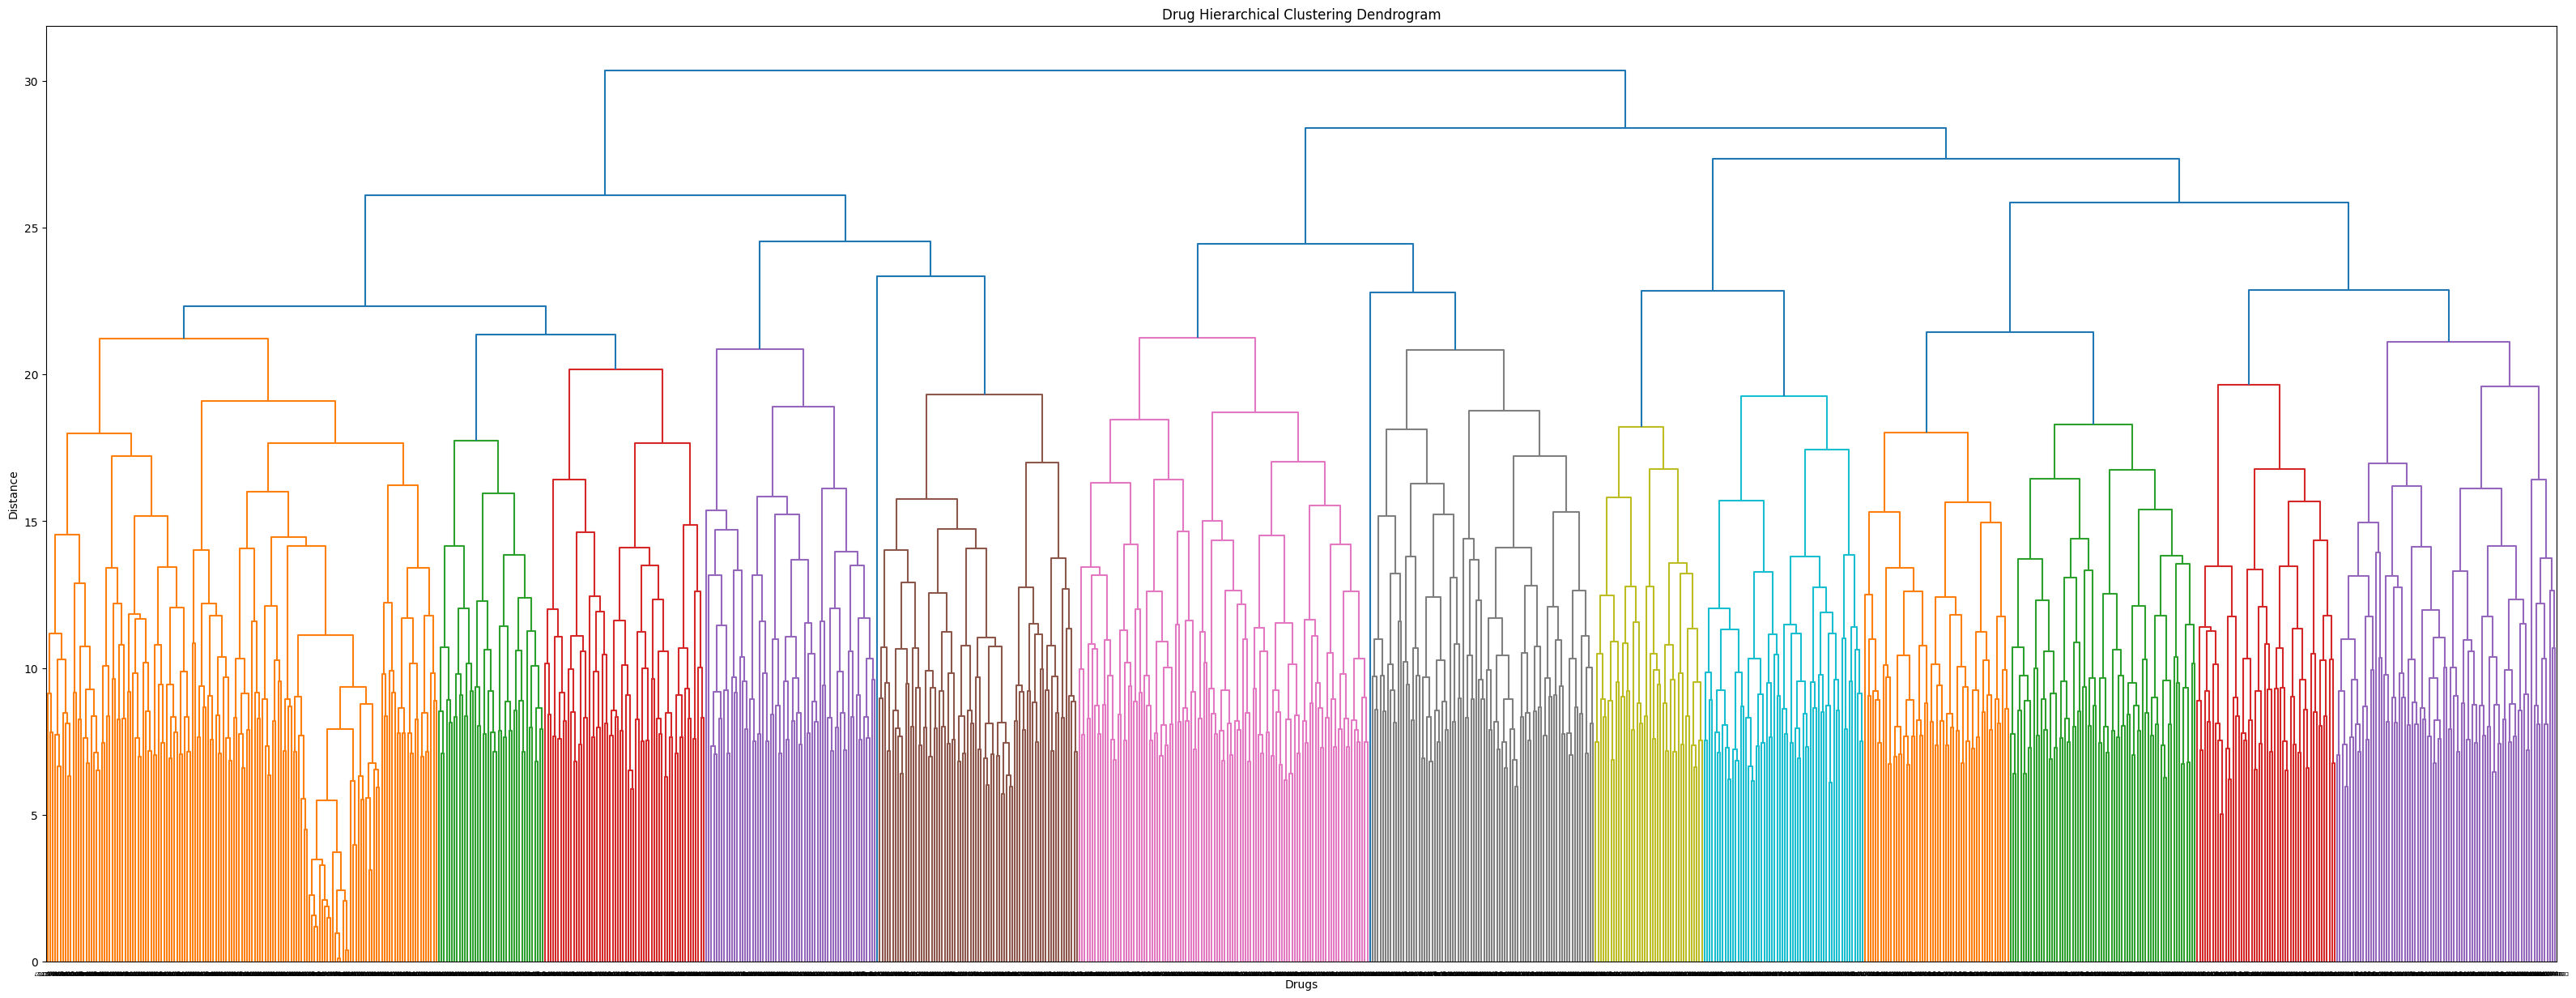

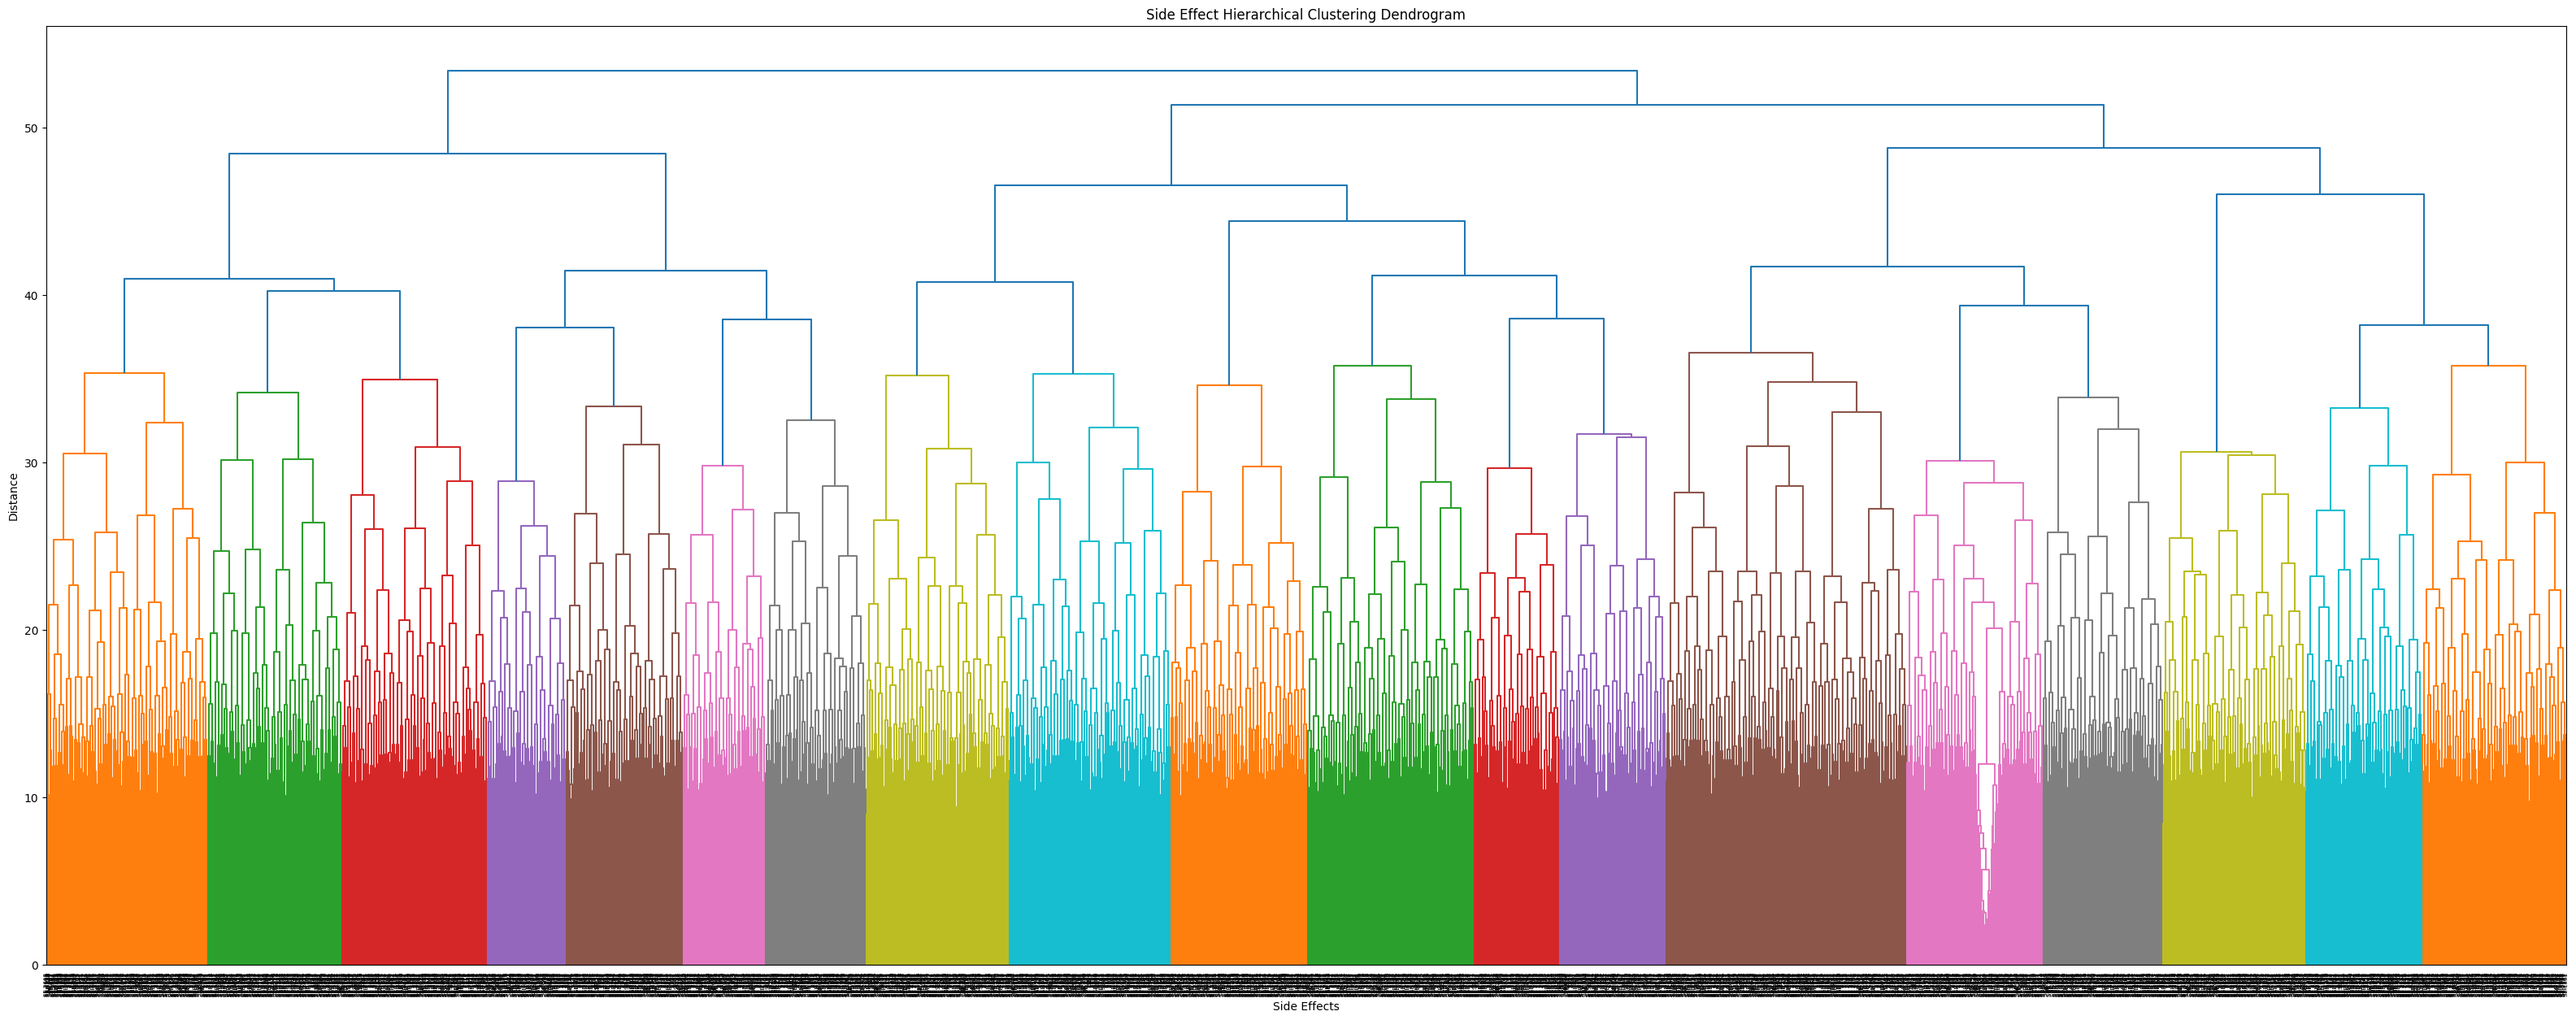

In [58]:
plots1 = create_plots(links1, drug_emb1, effect_emb1, dim_reduction="default", seed = 10)
plots1.dendrograms()

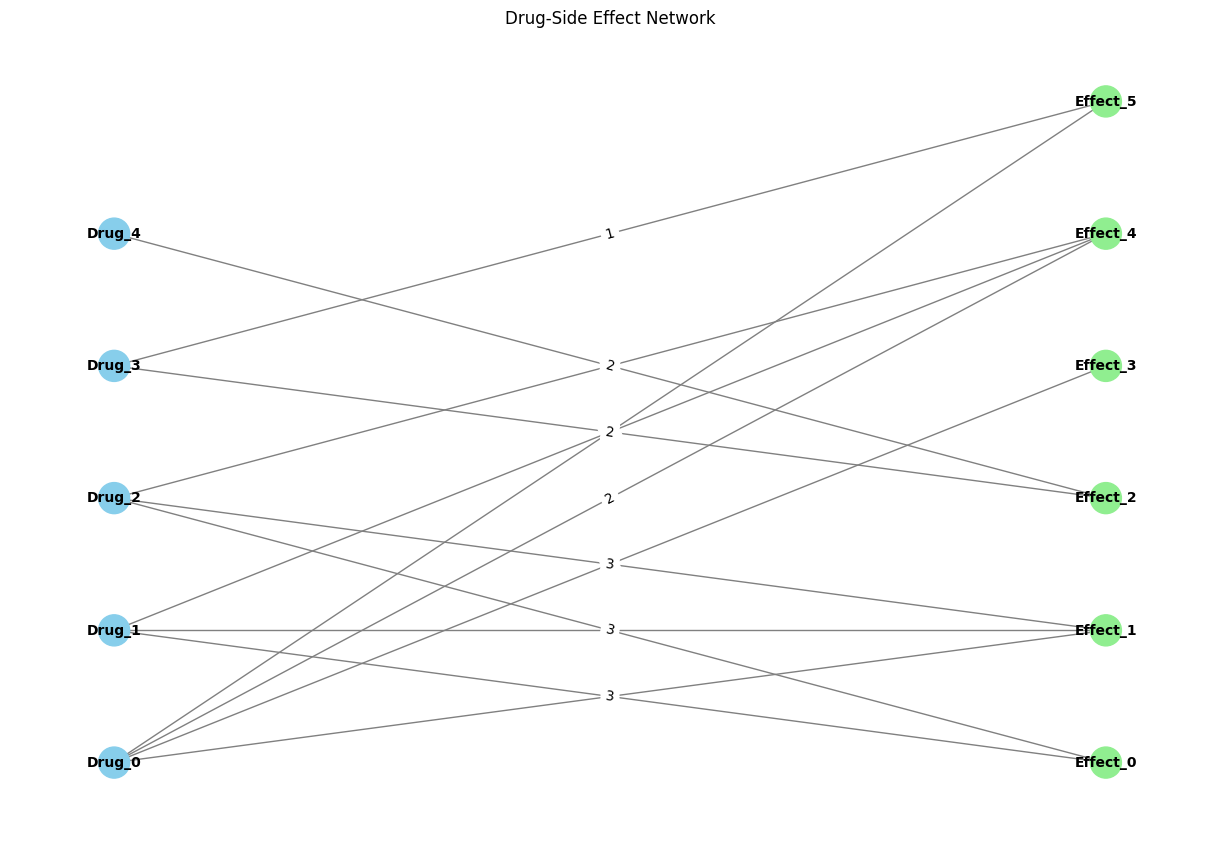

In [21]:
plots2 = create_plots(links2, drug_emb2, effect_emb2, dim_reduction="default", seed = 10)
plots2.simple_links()

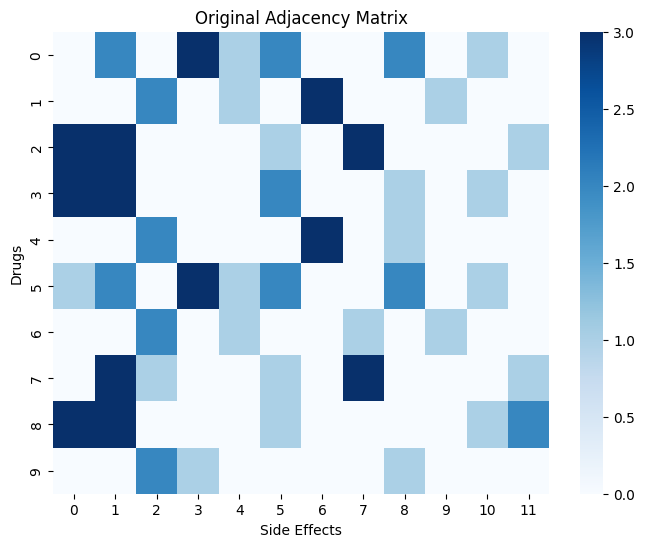

In [78]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(Aij.cpu().numpy(), cmap="Blues", cbar=True)
plt.title("Original Adjacency Matrix")
plt.xlabel("Side Effects")
plt.ylabel("Drugs")
plt.show()

In [233]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list

# Get latent embeddings
drug_embeddings = model.w.detach().cpu().numpy()  # w represents drugs
effect_embeddings = model.v.detach().cpu().numpy()  # v represents side effects

# Perform hierarchical clustering
drug_linkage = linkage(drug_embeddings, method="ward")
effect_linkage = linkage(effect_embeddings, method="ward")

# Get the new order of indices based on clustering
drug_order = leaves_list(drug_linkage)  # Reordered indices for drugs
effect_order = leaves_list(effect_linkage)  # Reordered indices for side effects

In [234]:
drug_order

array([0, 5, 3, 2, 8, 9, 1, 4, 6, 7], dtype=int32)

In [235]:
np.argsort(drug_linkage[:,0])

array([0, 1, 2, 3, 5, 4, 6, 7, 8])

In [87]:
drug_order

array([6, 9, 1, 4, 0, 5, 3, 7, 2, 8], dtype=int32)

In [237]:
drug_distance_matrix = squareform(pdist(drug_embeddings, metric="euclidean"))
reordered_drug_distance_matrix = drug_distance_matrix[drug_order][:, drug_order]
reordered_drug_distance_matrix

array([[ 0.        ,  2.3748487 ,  7.28391649,  6.94858445,  6.48752684,
         6.78991608,  7.6956172 ,  7.37793977,  8.55806463,  7.88585551],
       [ 2.3748487 ,  0.        ,  6.11597291,  6.277886  ,  5.70598207,
         6.57083398,  7.44574725,  7.4004518 ,  8.49256679,  8.34667323],
       [ 7.28391649,  6.11597291,  0.        ,  6.16295343,  5.21513058,
         9.81980503,  9.80276255,  9.25052989, 10.74176088,  9.03238323],
       [ 6.94858445,  6.277886  ,  6.16295343,  0.        ,  4.04498049,
         9.01292697,  7.70523067,  8.20775134,  7.673179  ,  5.85346712],
       [ 6.48752684,  5.70598207,  5.21513058,  4.04498049,  0.        ,
         8.92334778,  8.46711948,  8.25262005,  9.56702041,  7.38182325],
       [ 6.78991608,  6.57083398,  9.81980503,  9.01292697,  8.92334778,
         0.        ,  6.91332684,  5.68341186,  7.46268965,  9.25470983],
       [ 7.6956172 ,  7.44574725,  9.80276255,  7.70523067,  8.46711948,
         6.91332684,  0.        ,  3.72883049

In [61]:
Aij_reordered = Aij.cpu().numpy()[np.ix_(drug_order, effect_order)]

# Plot reordered adjacency matrix
plt.figure(figsize=(8, 6))
sns.heatmap(Aij_reordered, cmap="Blues", cbar=True, xticklabels=False, yticklabels=False)
plt.title("Reordered Adjacency Matrix")
plt.xlabel("Side Effects (Clustered)")
plt.ylabel("Drugs (Clustered)")
plt.show()

IndexError: index 859 is out of bounds for axis 0 with size 5

10 12


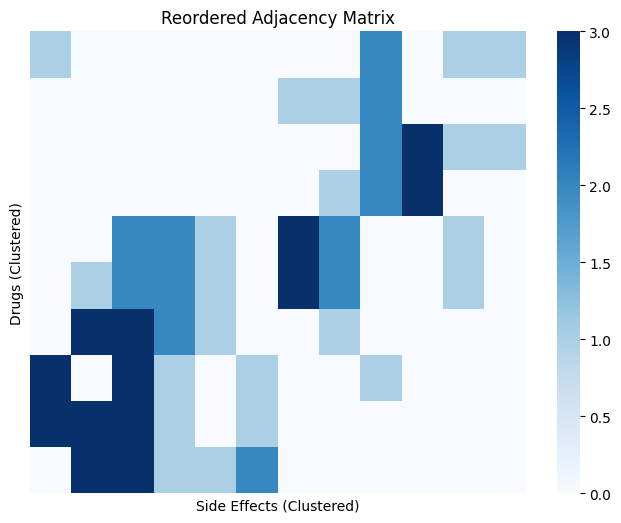

In [80]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

# Convert Aij to numpy
Aij_np = Aij.cpu().numpy()

# Get the correct number of drugs and side effects
n_drugs, n_effects = Aij_np.shape
print(n_drugs, n_effects)

# Ensure embeddings match the matrix shape
drug_embeddings = model.w.detach().cpu().numpy()[:n_drugs]  # Latent embeddings for drugs
effect_embeddings = model.v.detach().cpu().numpy()[:n_effects]  # Latent embeddings for side effects

# Perform hierarchical clustering only on available data
drug_linkage = linkage(drug_embeddings, method="ward")
effect_linkage = linkage(effect_embeddings, method="ward")

# Get new order of indices
drug_order = leaves_list(drug_linkage)
effect_order = leaves_list(effect_linkage)

# Ensure indices are within bounds
drug_order = np.clip(drug_order, 0, n_drugs - 1)
effect_order = np.clip(effect_order, 0, n_effects - 1)

# Reorder adjacency matrix
Aij_reordered = Aij_np[np.ix_(drug_order, effect_order)]

# Plot reordered adjacency matrix
plt.figure(figsize=(8, 6))
sns.heatmap(Aij_reordered, cmap="Blues", cbar=True, xticklabels=False, yticklabels=False)
plt.title("Reordered Adjacency Matrix")
plt.xlabel("Side Effects (Clustered)")
plt.ylabel("Drugs (Clustered)")
plt.show()


/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_51402/3160215829.py:7: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  drug_linkage = sch.linkage(drug_distances.cpu().numpy(), method='ward')
/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_51402/3160215829.py:11: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  side_effect_linkage = sch.linkage(side_effect_distances.cpu().numpy(), method='ward')


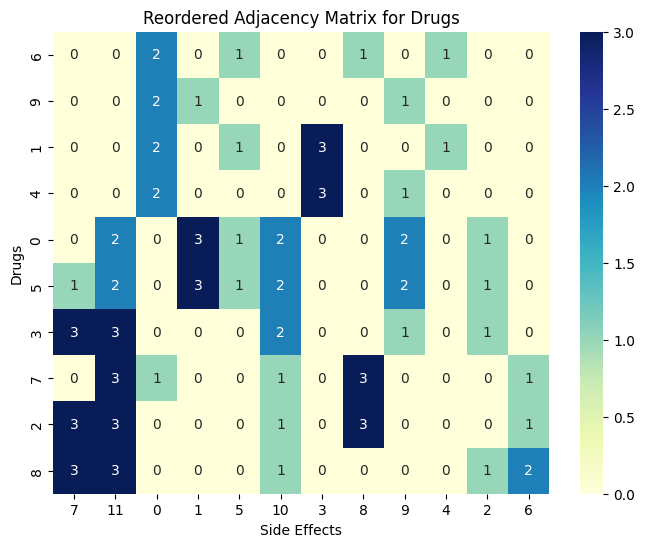

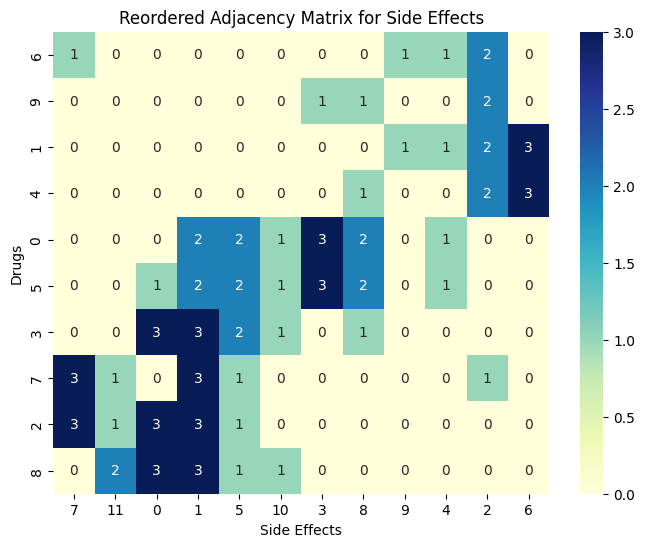

In [88]:
import scipy.cluster.hierarchy as sch
# Step 1: Perform hierarchical clustering on drugs (rows)
w, v = model.get_embeddings()
w = w.detach().cpu()
v = v.detach().cpu()
drug_distances = torch.cdist(w, w)  # Calculate pairwise distances for drugs
drug_linkage = sch.linkage(drug_distances.cpu().numpy(), method='ward')

# Step 2: Perform hierarchical clustering on side effects (columns)
side_effect_distances = torch.cdist(v, v)  # Calculate pairwise distances for side effects
side_effect_linkage = sch.linkage(side_effect_distances.cpu().numpy(), method='ward')

# Step 3: Get the order from the hierarchical clustering (dendrogram)
# Order the drugs and side effects by the hierarchical clustering
drug_order = sch.dendrogram(drug_linkage, no_plot=True)['leaves']
side_effect_order = sch.dendrogram(side_effect_linkage, no_plot=True)['leaves']

# Step 4: Reorder the adjacency matrix based on clustering
Aij_reordered_drugs = Aij[drug_order, :]  # Reorder rows (drugs)
Aij_reordered = Aij_reordered_drugs[:, side_effect_order]  # Reorder columns (side effects)

# Step 5: Plot the reordered adjacency matrix for drugs
plt.figure(figsize=(8, 6))
sns.heatmap(Aij_reordered_drugs.cpu().numpy(), cmap='YlGnBu', annot=True, fmt='g', xticklabels=side_effect_order, yticklabels=drug_order)
plt.title("Reordered Adjacency Matrix for Drugs")
plt.xlabel('Side Effects')
plt.ylabel('Drugs')
plt.show()

# Step 6: Plot the reordered adjacency matrix for side effects
plt.figure(figsize=(8, 6))
sns.heatmap(Aij_reordered.cpu().numpy(), cmap='YlGnBu', annot=True, fmt='g', xticklabels=side_effect_order, yticklabels=drug_order)
plt.title("Reordered Adjacency Matrix for Side Effects")
plt.xlabel('Side Effects')
plt.ylabel('Drugs')
plt.show()

In [110]:
import random

In [144]:
def create_holdout(Aij, holdout_ratio=0.1, seed=42):
    Aij_train = Aij.clone()
    if seed is not None:
        random.seed(seed)

    Aij_np = Aij.cpu().numpy()
    pos_cases = [(i,j) for i in range(Aij_np.shape[0]) for j in range(Aij_np.shape[1]) if Aij_np[i,j] > 0]
    neg_cases = [(i,j) for i in range(Aij_np.shape[0]) for j in range(Aij_np.shape[1]) if Aij_np[i,j]==0]

    # select holdtout cases randomly
    n_holdout_pos = int(len(pos_cases)*holdout_ratio)
    n_holdout_neg = int(len(neg_cases)*holdout_ratio)

    holdout_pos = random.sample(pos_cases, n_holdout_pos)
    holdout_neg = random.sample(neg_cases, n_holdout_neg)

    holdouts = holdout_pos + holdout_neg
    random.shuffle(holdouts)
    for i, j in holdouts:
        Aij_train[i,j]=0.0
    return Aij_train, holdouts


Aij_train, holdout_indices = create_holdout(Aij, holdout_ratio=0.1, seed=40)


In [118]:
Aij_train, Aij

(tensor([[0., 2., 0., 3., 0., 2., 0., 0., 2., 0., 1., 0.],
         [0., 0., 2., 0., 1., 0., 3., 0., 0., 1., 0., 0.],
         [3., 3., 0., 0., 0., 1., 0., 3., 0., 0., 0., 1.],
         [3., 3., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0.],
         [0., 0., 2., 0., 0., 0., 3., 0., 1., 0., 0., 0.],
         [1., 2., 0., 3., 1., 2., 0., 0., 2., 0., 0., 0.],
         [0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
         [0., 3., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
         [3., 3., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2.],
         [0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0.]]),
 tensor([[0., 2., 0., 3., 1., 2., 0., 0., 2., 0., 1., 0.],
         [0., 0., 2., 0., 1., 0., 3., 0., 0., 1., 0., 0.],
         [3., 3., 0., 0., 0., 1., 0., 3., 0., 0., 0., 1.],
         [3., 3., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0.],
         [0., 0., 2., 0., 0., 0., 3., 0., 1., 0., 0., 0.],
         [1., 2., 0., 3., 1., 2., 0., 0., 2., 0., 1., 0.],
         [0., 0., 2., 0., 1., 0., 0., 1., 0., 1., 0., 

In [188]:
from latent_distance_model import LDMprobit
model = LDMprobit(Aij, embedding_dim = 20, device=device, n_epochs=200, lr=0.01, seed=42)
model.train()

Epoch 0/200, Loss: 4.5480
Epoch 10/200, Loss: 3.0698
Epoch 20/200, Loss: 2.2587
Epoch 30/200, Loss: 1.8135
Epoch 40/200, Loss: 1.4778
Epoch 50/200, Loss: 1.2693
Epoch 60/200, Loss: 1.1412
Epoch 70/200, Loss: 1.0507
Epoch 80/200, Loss: 0.9813
Epoch 90/200, Loss: 0.9237
Epoch 100/200, Loss: 0.8738
Epoch 110/200, Loss: 0.8293
Epoch 120/200, Loss: 0.7893
Epoch 130/200, Loss: 0.7530
Epoch 140/200, Loss: 0.7199
Epoch 150/200, Loss: 0.6898
Epoch 160/200, Loss: 0.6622
Epoch 170/200, Loss: 0.6370
Epoch 180/200, Loss: 0.6139
Epoch 190/200, Loss: 0.5925


0.5747547745704651

In [179]:
links2, ordinal_vals2 = model.predict_categories()
links2

tensor([[0, 1, 0, 3, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0],
        [3, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [3, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0],
        [3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

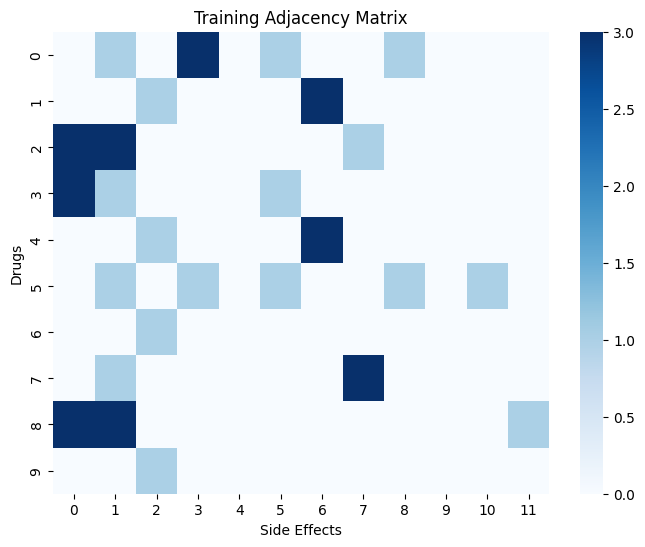

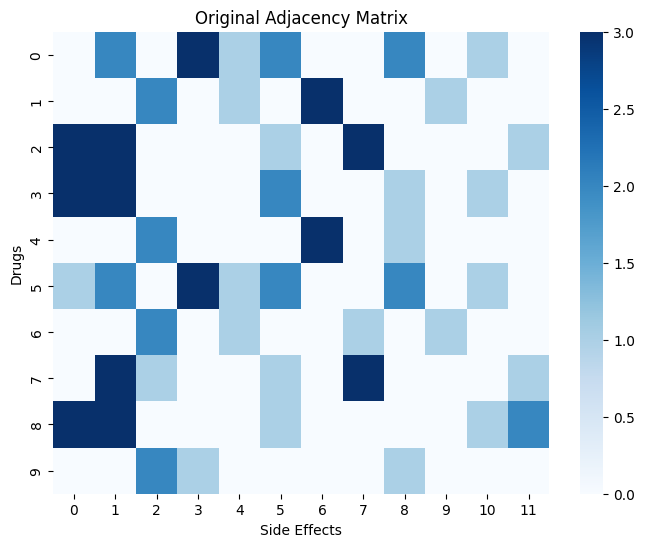

In [180]:
#plot Aij_train and Aij
plt.figure(figsize=(8, 6))
sns.heatmap(links2.cpu().numpy(), cmap="Blues", cbar=True)
plt.title("Training Adjacency Matrix")
plt.xlabel("Side Effects")
plt.ylabel("Drugs")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(Aij.cpu().numpy(), cmap="Blues", cbar=True)
plt.title("Original Adjacency Matrix")
plt.xlabel("Side Effects")
plt.ylabel("Drugs")
plt.show()


In [155]:
holdout_indices

[(4, 0),
 (1, 11),
 (0, 3),
 (7, 8),
 (0, 9),
 (2, 6),
 (4, 4),
 (1, 8),
 (3, 5),
 (1, 4),
 (8, 1)]

In [99]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

In [189]:
def evaluate_model(model, Aij_true, holdout_indices):
    model.eval_mode = True
    with torch.no_grad():
        preds, _ = model.predict_categories()
        preds_np = preds.cpu().numpy()
        true_hold_out_vals = []
        pred_hold_out_vals = []

        true_vals = []
        preds_vals = []
        #Evaluation on only the holdout indices
        for i, j in holdout_indices:
            true_val = Aij_true[i, j].item()
            pred_val = preds_np[i, j]
            if true_val > 0:  # Only use actual side effects
                true_hold_out_vals.append(1)
                pred_hold_out_vals.append(pred_val)  # Simplified to binary
            else:
                true_hold_out_vals.append(0)
                pred_hold_out_vals.append(0)

        for i in range(Aij_true.shape[0]):
            for j in range(Aij_true.shape[1]):
                true_val_all = Aij_true[i,j].item()
                pred_val_all = preds_np[i,j]
                if true_val_all >0:
                    true_vals.append(1)
                    preds_vals.append(pred_val_all > 0)
                else:
                    true_hold_out_vals.append(0)
                    pred_hold_out_vals.append(0)
        #Total evaluation on entire matrix
        Aij_true = Aij_true.detach().cpu().numpy()
        n_corrects = np.sum(preds_np == Aij_true)
        r, c = preds_np.shape
        n_correctness = n_corrects/(r*c)
        

        auc_roc = roc_auc_score(true_hold_out_vals, pred_hold_out_vals)
        auc_pr = average_precision_score(true_hold_out_vals, pred_hold_out_vals)
    return auc_roc, auc_pr, n_correctness

In [223]:
def evaluate_model_binary(model, Aij_true, test_indices=None):
    model.eval_mode = True
    with torch.no_grad():
        preds, _ = model.predict_categories()
        preds_np = preds.cpu().numpy()
        
        #Setting values to 0 or 1
        preds_np = np.where(preds_np > 0, 1, 0)
        Aij_true = Aij_true.detach().cpu().numpy()
        Aij_true = np.where(Aij_true > 0, 1, 0)

        true_vals = []
        pred_vals = []

        if test_indices is not None:
                    for i, j in test_indices:
                        true_vals.append(Aij_true[i, j])
                        pred_vals.append(preds_np[i, j])
        else:
            for i in range(Aij_true.shape[0]):
                for j in range(Aij_true.shape[1]):
                    true_vals.append(Aij_true[i, j])
                    pred_vals.append(preds_np[i, j])

        auc_roc = roc_auc_score(true_vals, pred_vals)
        auc_pr = average_precision_score(true_vals, pred_vals)

    return auc_roc, auc_pr

In [229]:
from model import LDM
embedding_dims = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
results = []

# Store standard deviations
std_aucs = []
std_prs = []

for D in embedding_dims:
    auc_rocs = []
    auc_prs = []
    for i in range(20): 
        #Aij_train, holdout_indices = create_holdout(Aij, holdout_ratio=0.1, seed = i)
        Aij_train = Aij
        model = LDM(Aij_train, embedding_dim=D, device=device, n_epochs=200, lr=0.01, seed=i)
        model.train()
        
        auc_roc, auc_pr = evaluate_model_binary(model, Aij)
        auc_rocs.append(auc_roc)
        auc_prs.append(auc_pr)

    std_auc_roc = np.std(auc_rocs)
    std_auc_pr = np.std(auc_prs)
    results.append((D, np.mean(auc_rocs), np.mean(auc_prs)))
    std_aucs.append(std_auc_roc)
    std_prs.append(std_auc_pr)
    print(f"D={D} | MEAN-AUC-ROC: {np.mean(auc_rocs):.3f} ± {std_auc_roc:.3f} | MEAN-AUC-PR: {np.mean(auc_prs):.3f} ± {std_auc_pr:.3f}")

D=2 | MEAN-AUC-ROC: 0.532 ± 0.045 | MEAN-AUC-PR: 0.427 ± 0.047
D=4 | MEAN-AUC-ROC: 0.627 ± 0.098 | MEAN-AUC-PR: 0.544 ± 0.120
D=6 | MEAN-AUC-ROC: 0.656 ± 0.084 | MEAN-AUC-PR: 0.581 ± 0.102
D=8 | MEAN-AUC-ROC: 0.683 ± 0.115 | MEAN-AUC-PR: 0.613 ± 0.140
D=10 | MEAN-AUC-ROC: 0.669 ± 0.089 | MEAN-AUC-PR: 0.597 ± 0.108
D=12 | MEAN-AUC-ROC: 0.677 ± 0.124 | MEAN-AUC-PR: 0.607 ± 0.151
D=14 | MEAN-AUC-ROC: 0.728 ± 0.117 | MEAN-AUC-PR: 0.669 ± 0.142
D=16 | MEAN-AUC-ROC: 0.743 ± 0.101 | MEAN-AUC-PR: 0.687 ± 0.123
D=18 | MEAN-AUC-ROC: 0.705 ± 0.122 | MEAN-AUC-PR: 0.641 ± 0.149
D=20 | MEAN-AUC-ROC: 0.710 ± 0.127 | MEAN-AUC-PR: 0.647 ± 0.154


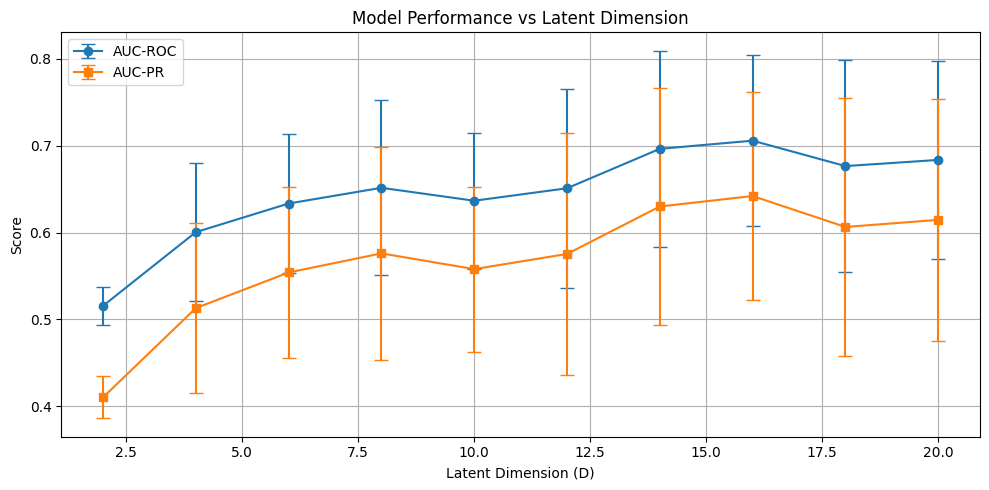

In [228]:
#plotting results
import matplotlib.pyplot as plt
dims, auc_rocs, auc_prs = zip(*results)

plt.figure(figsize=(10, 5))
plt.errorbar(dims, auc_rocs, yerr=std_aucs, label='AUC-ROC', marker='o', capsize=5)
plt.errorbar(dims, auc_prs, yerr=std_prs, label='AUC-PR', marker='s', capsize=5)
plt.xlabel("Latent Dimension (D)")
plt.ylabel("Score")
plt.title("Model Performance vs Latent Dimension")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [226]:
from sklearn.model_selection import KFold

def get_nonzero_indices(Aij):
    return torch.nonzero(Aij, as_tuple=False)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
embedding_dims = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
results = []
std_aucs = []
std_prs = []

observed_indices = get_nonzero_indices(Aij)

for D in embedding_dims:
    fold_roc = []
    fold_pr = []
    
    for train_idx, test_idx in kf.split(observed_indices):
        train_entries = observed_indices[train_idx]
        test_entries = observed_indices[test_idx]

        # Create train matrix
        Aij_train = torch.zeros_like(Aij)
        Aij_train[train_entries[:, 0], train_entries[:, 1]] = Aij[train_entries[:, 0], train_entries[:, 1]]

        model = LDM(Aij_train, embedding_dim=D, device=device, n_epochs=200, lr=0.01)
        model.train()

        auc_roc, auc_pr = evaluate_model_binary(model, Aij, test_entries)
        fold_roc.append(auc_roc)
        fold_pr.append(auc_pr)

    mean_roc = np.mean(fold_roc)
    mean_pr = np.mean(fold_pr)
    std_roc = np.std(fold_roc)
    std_pr = np.std(fold_pr)
    
    results.append((D, mean_roc, mean_pr))
    std_aucs.append(std_roc)
    std_prs.append(std_pr)
    
    print(f"D={D} | CV-AUC-ROC: {mean_roc:.3f} ± {std_roc:.3f} | CV-AUC-PR: {mean_pr:.3f} ± {std_pr:.3f}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.1

D=2 | CV-AUC-ROC: nan ± nan | CV-AUC-PR: 1.000 ± 0.000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


D=4 | CV-AUC-ROC: nan ± nan | CV-AUC-PR: 1.000 ± 0.000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.1

D=6 | CV-AUC-ROC: nan ± nan | CV-AUC-PR: 1.000 ± 0.000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


D=8 | CV-AUC-ROC: nan ± nan | CV-AUC-PR: 1.000 ± 0.000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.1

D=10 | CV-AUC-ROC: nan ± nan | CV-AUC-PR: 1.000 ± 0.000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


D=12 | CV-AUC-ROC: nan ± nan | CV-AUC-PR: 1.000 ± 0.000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.1

D=14 | CV-AUC-ROC: nan ± nan | CV-AUC-PR: 1.000 ± 0.000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


D=16 | CV-AUC-ROC: nan ± nan | CV-AUC-PR: 1.000 ± 0.000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.1

D=18 | CV-AUC-ROC: nan ± nan | CV-AUC-PR: 1.000 ± 0.000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


D=20 | CV-AUC-ROC: nan ± nan | CV-AUC-PR: 1.000 ± 0.000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


## Neural network for mapping features to latent representation

In [3]:
from model import LDM

In [85]:
def load_data(path_to_csv, device):
    df = pd.read_csv(path_to_csv, index_col=0)
    Aij = torch.tensor(df.values, dtype=torch.float32).to(device)
    return Aij

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
csv_path = "/Users/christine/Bachelor/src/data/adj_matrix.csv" 
Aij_real = load_data(csv_path, device)
print(Aij_real.shape)

torch.Size([968, 3964])


In [83]:
#importing the data
feature_vec = pd.read_csv('/Users/christine/LatentDistanceModel/data/feature_vector.tsv', sep='\t')
feature_vec.drop(columns=['Unnamed: 0'], inplace=True)
feature_vec

,0,Chewing gum,Inhal,Inhal.aerosol,Inhal.powder,Inhal.solution,N,O,P,R,...,V08AB05,V08AB06,V08AB07,V08AB09,V08CA03,V08CA04,V08CA06,V08CA08,V08CA09,V09AB03
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
#find indexing for the two vectors
adj_matrix_names = pd.read_csv('/Users/christine/LatentDistanceModel/data/adj_matrix_names.csv', sep='\t')
adj_matrix_idx = adj_matrix_names['Stitch flat']
adj_matrix_idx = adj_matrix_idx.to_numpy()

#index of feature vector
feature_vector_names = pd.read_csv('/Users/christine/LatentDistanceModel/data/feature_vector_names.tsv', sep = '\t', )
feature_vector_names['ID Adm.Rs'] = feature_vector_names['ID Adm.Rs'].str.split('_').str[0]
feature_vector_idx = feature_vector_names['ID Adm.Rs'].to_numpy()
adj_matrix_idx, feature_vector_idx

(array(['CID100000085', 'CID100000137', 'CID100000143', 'CID100000158',
        'CID100000159', 'CID100000160', 'CID100000191', 'CID100000214',
        'CID100000232', 'CID100000247', 'CID100000271', 'CID100000311',
        'CID100000444', 'CID100000450', 'CID100000453', 'CID100000581',
        'CID100000596', 'CID100000598', 'CID100000699', 'CID100000700',
        'CID100000727', 'CID100000738', 'CID100000750', 'CID100000772',
        'CID100000813', 'CID100000861', 'CID100000923', 'CID100000937',
        'CID100000942', 'CID100001003', 'CID100001065', 'CID100001125',
        'CID100001134', 'CID100001301', 'CID100001546', 'CID100001690',
        'CID100001727', 'CID100001775', 'CID100001805', 'CID100001971',
        'CID100001972', 'CID100001978', 'CID100001983', 'CID100001990',
        'CID100002019', 'CID100002022', 'CID100002082', 'CID100002083',
        'CID100002088', 'CID100002092', 'CID100002094', 'CID100002099',
        'CID100002118', 'CID100002130', 'CID100002153', 'CID1000

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 14
Aij = torch.tensor([[0, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0], 
                    [0, 0, 2, 0, 1, 0, 3, 0, 0, 1, 0, 0],
                    [3, 3, 0, 0, 0, 1, 0, 3, 0, 0, 0, 1],
                    [3, 3, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0],
                    [0, 0, 2, 0, 0, 0, 3, 0, 1, 0, 0, 0],
                    [1, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0], 
                    [0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0],
                    [0, 3, 1, 0, 0, 1, 0, 3, 0, 0, 0, 1],
                    [3, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2],
                    [0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0]],dtype=torch.float32, device=device)
lr = 0.01
seed = 20
ldm_trained = LDM(Aij, embedding_dim, device, n_epochs, lr, seed)
ldm_trained.train()
Aij_probs_true = ldm_trained.probit()  # Compute the probit probability matrix
loss_out = ldm_trained.train()
w, v = ldm_trained.get_embeddings()

In [50]:
f_vec = torch.tensor([[0, 1, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 300, 0, 0, 0], 
                      [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 300, 0, 0, 0], 
                      [0, 0, 0, 0, 1, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0], 
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 0], 
                      [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0],
                      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0], 
                      [0, 0, 0, 1, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0], 
                      [0, 1, 0, 0, 0, 0, 34, 0, 0, 0, 0, 0, 0, 0, 0], 
                      [1, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17]
                      ], dtype=torch.float32, device=device)
Aij_names = adj_matrix_idx[0:Aij.shape[0]]
Aij_idx = {drug_id: idx for idx, drug_id in enumerate(Aij_names)}
Aij_idx = np.array([Aij_idx[drug_id] for drug_id in Aij_names])
f_vec_idx = np.array([0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9])
print(f'Aij_idx: {Aij_idx}. There are {Aij.shape[0]} drugs in Aij and {len(Aij_idx)} drugs in the index.\nf_vec_idx: {f_vec_idx}. There are {f_vec.shape[0]} drugs in f_vec and {len(f_vec_idx)} drugs in the index.')

Aij_idx: [0 1 2 3 4 5 6 7 8 9]. There are 10 drugs in Aij and 10 drugs in the index.
f_vec_idx: [0 0 1 1 2 3 4 5 6 7 8 9]. There are 12 drugs in f_vec and 12 drugs in the index.


In [77]:
adj_matrix_names

,Stitch flat,5'nucleotidase increased,AION,AML progression,Abdominal abscess,Abdominal adhesions,Abdominal aortic aneurysm,Abdominal bloating,Abdominal colic,Abdominal cramps,...,Xanthoma,Xanthopsia,Xeroderma,Xerophthalmia,Xerosis,Yawning,Yeast infection,Yellow skin,Zollinger-Ellison syndrome,pH urine increased
0,CID100000085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CID100000137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CID100000143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CID100000158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CID100000159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,CID154687131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
964,CID156603655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
965,CID156842239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
966,CID170695640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
#for real data
Aij_dic = {drug_id: idx for idx, drug_id in enumerate(adj_matrix_idx)}
unique_drugs_Aij = pd.unique(adj_matrix_idx)
Aij_idx = np.array([Aij_dic[drug_id] for drug_id in adj_matrix_names['Stitch flat']])
unique_drugs_f = pd.unique(feature_vector_idx)
f_dic = {drug_id: idx for idx, drug_id in enumerate(unique_drugs_f)}
f_idx = np.array([f_dic[drug_id] for drug_id in feature_vector_names['ID Adm.Rs']])
f_idx

array([  0,   0,   1, ..., 742, 743, 744], shape=(1095,))

In [76]:
only_in_Aij = set(unique_drugs_Aij) - set(unique_drugs_f)
only_in_f = set(unique_drugs_f) - set(unique_drugs_Aij)
not_in_both = only_in_Aij.union(only_in_f)
print(f"Only in Aij: {only_in_Aij}\nOnly in feature vector: {only_in_f}\nNot in either: {not_in_both}")
print(f"{len(only_in_Aij)} are missing from feature vector")

Only in Aij: {'CID100003368', 'CID106442177', 'CID109871419', 'CID100054331', 'CID109924495', 'CID100489129', 'CID124826799', 'CID100003750', 'CID109800339', 'CID100005040', 'CID111234049', 'CID100000923', 'CID100006451', 'CID100208908', 'CID106850791', 'CID144564722', 'CID111519069', 'CID100064987', 'CID106440191', 'CID100001727', 'CID154682541', 'CID109831783', 'CID100002914', 'CID100004735', 'CID116156130', 'CID109825285', 'CID100130564', 'CID111499245', 'CID100060183', 'CID144201342', 'CID100071360', 'CID100216258', 'CID105328940', 'CID100125889', 'CID100107994', 'CID106918366', 'CID100160352', 'CID124965990', 'CID100132971', 'CID100062956', 'CID156842239', 'CID124822371', 'CID144201343', 'CID106433082', 'CID124762228', 'CID111254352', 'CID100057166', 'CID109940864', 'CID111505907', 'CID100004271', 'CID100005409', 'CID100107969', 'CID100006432', 'CID125094462', 'CID115951529', 'CID100003446', 'CID103086686', 'CID100213046', 'CID100160036', 'CID111556711', 'CID100023925', 'CID100023

In [7]:
#convert to tensor
import numpy as np
feature_tensor = torch.tensor(feature_vec.astype(np.float32).to_numpy(), dtype=torch.float32)

In [10]:
class FeatureMapping(nn.Module):
    def __init__(self, feature_vector: feature_vec, LatentModel: ldm_trained):
        super().__init__()
        self.feature_vec = feature_vec
        
        #inherited parameters
        self.beta = nn.Parameter(LatentModel.beta.clone().detach(), requires_grad=False)
        self.w = torch.nn.Parameter(LatentModel.w.clone().detach(), requires_grad=False)  # Latent embeddings for drugs
        self.v = torch.nn.Parameter(LatentModel.v.clone().detach(), requires_grad=False)  # Latent embeddings for side effects
        self.beta_thilde = nn.Parameter(LatentModel.beta_thilde.clone().detach(), requires_grad=False)
        self.a = nn.Parameter(LatentModel.a.clone().detach(), requires_grad=False)
        self.b = nn.Parameter(LatentModel.b.clone().detach(), requires_grad=False)

        # shapes 
        self.n_drugs = self.w.shape[0]
        self.n_effects = self.v.shape[0]
        self.n_ordinal_classes = self.beta_thilde.shape[0]
        self.n_features = feature_vector.shape[0]
        self.embedding_dim = self.w.shape[1]

        #neural net
        self.feature_net = nn.Sequential(
            nn.Linear(self.n_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, self.embedding_dim)
        )

    def _get_params(self):
        return self.beta, self.w
    
    def forward(self, drug_idx, effect_idx, feature_vector):
        w = self.w[drug_idx]

        v = 
        

In [16]:
mapping_model = FeatureMapping(feature_vec, ldm_trained)
# beta, w = mapping_model._get_params()
# w.shape

torch.Size([10, 10])

In [2]:
class FeatureMapper(nn.Module):
    def __init__(self, input_dim, embedding_dim, dropout = 0.1):
        super(FeatureMapper, self).__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim

        self.feature_net = nn.Sequential(
            nn.Linear(self.input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(16, self.embedding_dim)
        )

    def forward(self, x):
        return self.feature_net(x)

NameError: name 'nn' is not defined

In [55]:
mapper = FeatureMapper(input_dim=f_vec.shape[1], embedding_dim=w.shape[1])
optimizer = torch.optim.Adam(mapper.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
num_epochs = 100

w_frozen = ldm_trained.w.detach().clone()
f_vec_tensor = torch.tensor(f_vec, dtype=torch.float32)
drug_idx_tensor = torch.tensor(f_vec_idx, dtype=torch.long)
w_tensor = torch.tensor(w, dtype=torch.float32)

for epoch in range(num_epochs):
    mapper.train()
    optimizer.zero_grad()

    z_pred = mapper(f_vec_tensor)
    z_true = w_tensor[drug_idx_tensor]
    loss = loss_fn(z_pred, z_true)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 21.8214
Epoch 1, Loss: 19.6411
Epoch 2, Loss: 16.2094
Epoch 3, Loss: 14.3699
Epoch 4, Loss: 15.2734
Epoch 5, Loss: 14.7081
Epoch 6, Loss: 14.2228
Epoch 7, Loss: 12.2970
Epoch 8, Loss: 11.9064
Epoch 9, Loss: 11.6490
Epoch 10, Loss: 10.5198
Epoch 11, Loss: 10.8447
Epoch 12, Loss: 10.9064
Epoch 13, Loss: 10.0476
Epoch 14, Loss: 10.5434
Epoch 15, Loss: 10.0452
Epoch 16, Loss: 9.7699
Epoch 17, Loss: 9.1964
Epoch 18, Loss: 9.8209
Epoch 19, Loss: 9.1574
Epoch 20, Loss: 9.0290
Epoch 21, Loss: 9.2171
Epoch 22, Loss: 9.3287
Epoch 23, Loss: 8.8057
Epoch 24, Loss: 9.2749
Epoch 25, Loss: 8.7241
Epoch 26, Loss: 9.3201
Epoch 27, Loss: 8.7440
Epoch 28, Loss: 8.3668
Epoch 29, Loss: 8.2857
Epoch 30, Loss: 8.7089
Epoch 31, Loss: 8.2935
Epoch 32, Loss: 7.9290
Epoch 33, Loss: 7.9340
Epoch 34, Loss: 8.1716
Epoch 35, Loss: 7.7946
Epoch 36, Loss: 8.4823
Epoch 37, Loss: 7.7704
Epoch 38, Loss: 7.8584
Epoch 39, Loss: 7.5988
Epoch 40, Loss: 7.5485
Epoch 41, Loss: 7.6687
Epoch 42, Loss: 8.3598
Epoch

/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_12355/2716361696.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f_vec_tensor = torch.tensor(f_vec, dtype=torch.float32)
/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_12355/2716361696.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_tensor = torch.tensor(w, dtype=torch.float32)


## Real data

In [93]:
Aij_real.shape

torch.Size([968, 3964])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 140
lr = 0.01
seed = 20
ldm_trained_r = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed)
ldm_trained_r.train()
Aij_probs_true_r = ldm_trained_r.probit()  # Compute the probit probability matrix
loss_out_r = ldm_trained_r.train()
w_r, v_r = ldm_trained_r.get_embeddings()

In [91]:
w_frozen = ldm_trained.w.detach().clone()
feature_vec_tensor = torch.tensor(feature_vec.astype(np.float32).to_numpy(), dtype=torch.float32)
feature_idx_tensor = torch.tensor(f_idx, dtype=torch.long)
w_tensor = torch.tensor(w, dtype=torch.float32)

/var/folders/nd/td49stzx1sb1x3vskq7xg2540000gn/T/ipykernel_12355/1346785930.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_tensor = torch.tensor(w, dtype=torch.float32)


Løsningen er end to end. Træner hele modellen igennem med netværket. propagere gradienter igennem projektioner,  

Prædektere side effect seperat, probit til hver side effect seperat - det svarer til mange 1000 modeller. 
Hav en baseline der afspejler imbalance, gæt som baggrundsfordeling
Træn en GNN standard bipartite
prædektere for hver enkel side effect ud fra hvor hyppigt, hvor mange er 0,1 osv
